# TIME SERIES ANALYSIS
 Goal: Find outliers, trends and periodicity in the MTA turnstile data

### 1. Read Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import datetime as dt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
mtaRides = np.load("MTA_Fare.npy").astype(float)
mtaRides.shape

(600, 23, 194)

In [3]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [4]:
np.place(mtaRides, mtaRides == -1, np.nan)

In [5]:
start = dt.date(2010, 5, 21)
end = dt.date(2014, 2, 21)
dtr = pd.date_range(start, end, freq='w').tolist()

len(dtr)

196

### 2. Event Detection

In [6]:
data = np.nansum(np.nansum(mtaRides, axis = 0), axis = 0)

In [7]:
mean = np.nanmean(data)
std = np.nanstd(data)
thresholds = [mean - 3*std, mean + 3*std]
point = np.where ((data < thresholds[0]) | (data > thresholds[1]))
point[0]

dtr[point[0][0] + 1]

Timestamp('2012-10-28 00:00:00', offset='W-SUN')

The data detects a dominate event that Hurricane Sandy boarded during the week starting from 2012-10-28.

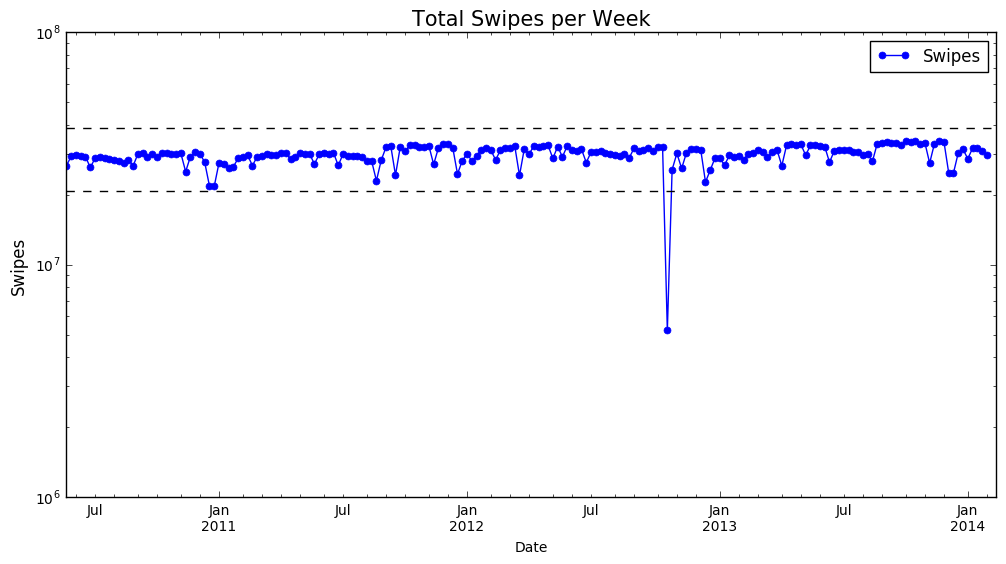

In [8]:
dp = pd.concat([pd.DataFrame(dtr), pd.DataFrame(data)], axis=1)
dp.columns = ['Date', 'Swipes']
dp.set_index(keys = ['Date'], inplace=True)
ax = dp.plot(logy=True, figsize=(12,6), style=".-", ms=10, color="Blue")
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]], 'k--', lw=1)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], 'k--', lw=1)
ax.set_ylabel('Swipes', fontsize= 12)
ax.set_title('Total Swipes per Week', fontsize = 15)

### 3. Trends Detection

In [9]:
data2 = pd.DataFrame(np.nansum(mtaRides, axis=0).T, columns=ridetype)
dt2_rm = data2.rolling(10).mean()

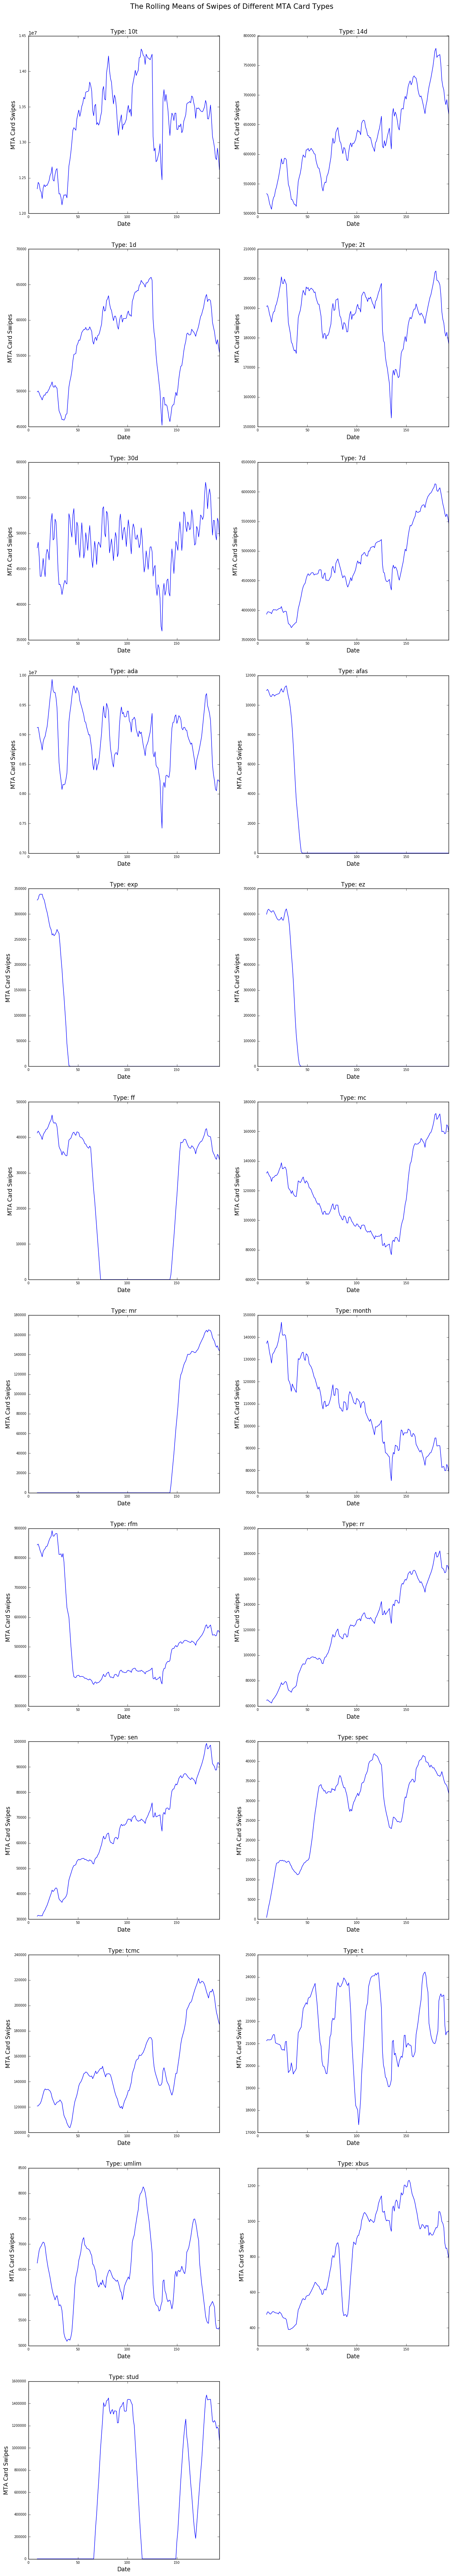

In [10]:
fig = pl.figure(figsize=(16,96))
pl.suptitle('The Rolling Means of Swipes of Different MTA Card Types', fontsize=15, y=0.91)
for i in range(23):
    ax = fig.add_subplot(12,2,i+1)
    ax = dt2_rm.iloc[:,i].plot(fontsize=7)
    ax.set_title('Type: {}'.format(ridetype[i]), fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('MTA Card Swipes', fontsize=12)
pl.show()

There are seven types of MTA cards having steady trends of swipes in time series. They are 14d, 7d, month, rr, sen, tcmc, xbus and spec.

In [11]:
trend = np.array(['14d', '7d', 'month', 'rr', 'sen', 'tcmc', 'xbus', 'spec'])

In [12]:
print("The ratio of usage in the first 10 and last 10 weeks:")
for col in trend:
    ratio = np.mean(data2[col][:10]) / np.mean(data2[col][-10:])
    print("For Ride Type {}:\n  the trend ratio is {}".format(col, ratio))

The ratio of usage in the first 10 and last 10 weeks:
For Ride Type 14d:
  the trend ratio is 0.79868054602
For Ride Type 7d:
  the trend ratio is 0.719555117345
For Ride Type month:
  the trend ratio is 1.72794422105
For Ride Type rr:
  the trend ratio is 0.385659649203
For Ride Type sen:
  the trend ratio is 0.343713862169
For Ride Type tcmc:
  the trend ratio is 0.652626042706
For Ride Type xbus:
  the trend ratio is 0.601566447701
For Ride Type spec:
  the trend ratio is 0.0142485908332


### 4. Peroids Detection

In [13]:
data3 = np.nansum(mtaRides, axis = 1)

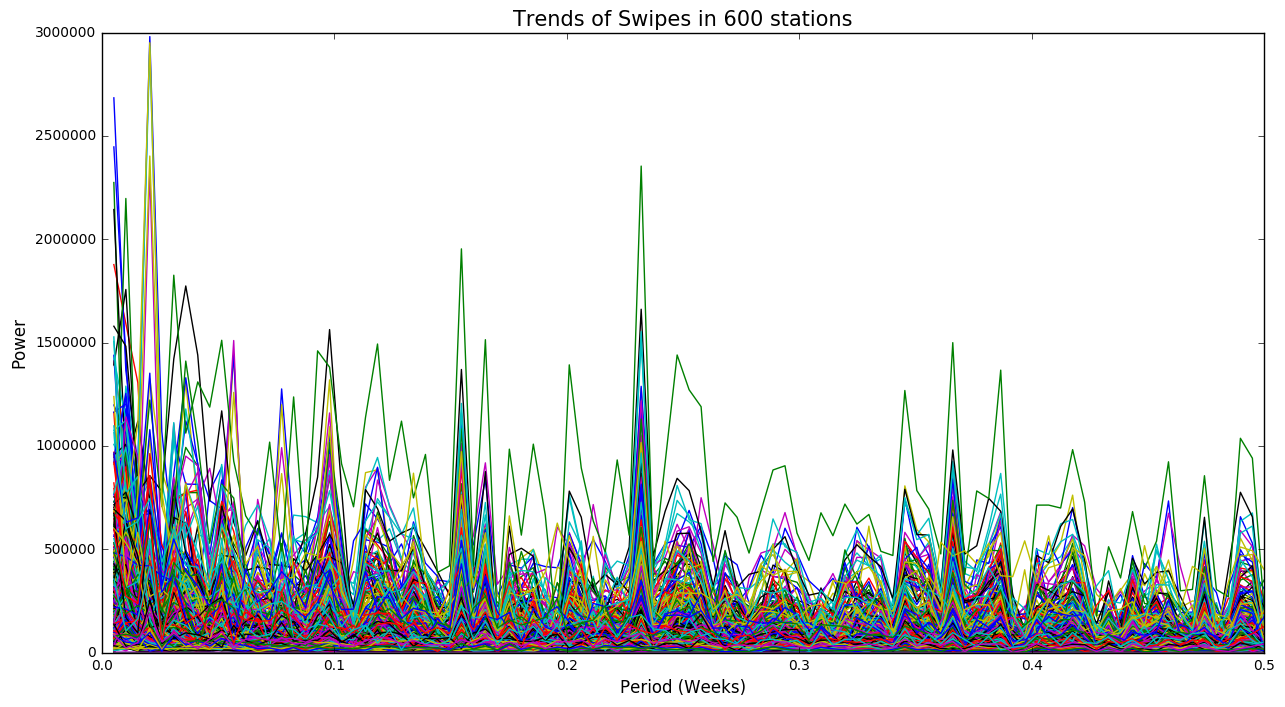

In [14]:
pl.figure(figsize=(15,8))
peak = []
xrange = np.fft.rfftfreq(194, 1)[1:]
for i in range(600):
    f = np.abs(np.fft.rfft(data3[i])[1:])
    peak.append(f[3])
    pl.plot(xrange, f)
pl.xlabel('Period (Weeks)', fontsize=12)
pl.ylabel('Power', fontsize=12)
pl.title('Trends of Swipes in 600 stations', fontsize=15)
pl.show()

In [15]:
peak = np.array(peak)
sort = np.argsort(peak)[::-1]
mask = np.where(~np.isnan(peak[sort]))[0]
stations = sort[mask][:4]

In [16]:
print('The 4 station that show the most prominent periodic trend on an annual period')
pd.DataFrame(stations.T, columns=['Station index'])

The 4 station that show the most prominent periodic trend on an annual period


,Station index
0,0
1,194
2,150
3,327


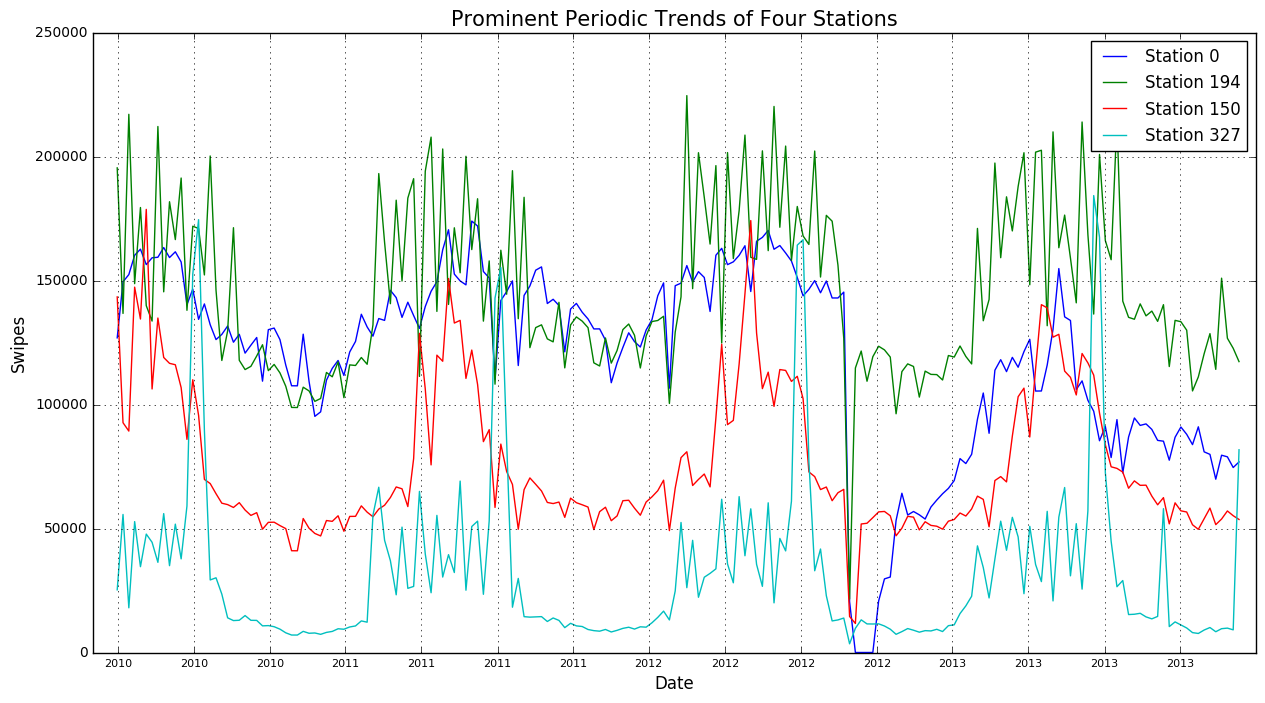

In [18]:
dtr1 = dtr[1:195]
pl.figure(figsize=(15,8))
daterange = pd.date_range(start, end, freq='3m').tolist()
for i in stations:
    pl.plot(dtr1, data3[i], label = "Station "+str(i))
pl.title("Prominent Periodic Trends of Four Stations", fontsize=15)
pl.xlabel('Date', fontsize=12)
pl.ylabel('Swipes', fontsize=12)
pl.xlim(dt.date(2010,5,1), dt.date(2014,3,1))
pl.xticks(daterange, fontsize=8)
pl.legend(loc = "best")
pl.grid(True)
pl.show()

### 5. Cluster

In [20]:
tots = mtaRides.transpose(2,0,1).reshape(mtaRides.shape[2], mtaRides.shape[1]*mtaRides.shape[0]).T
tots = tots[tots.std(1)>0]
tots_vals = (tots - np.nanmean(tots, axis=0)) / np.nanstd(tots, axis=0)

In [23]:
import statsmodels.api as sm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.decomposition import PCA

In [24]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = pl.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    pl.grid(True)
    pl.xlabel('Number of clusters')
    pl.ylabel('Average within-cluster sum of squares')
    pl.title('Elbow for KMeans clustering')
    pl.show()
    
# Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = pl.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    pl.grid(True)
    pl.xlabel('Number of clusters')
    pl.ylabel('Percentage of variance explained')
    pl.title('Elbow for KMeans clustering')
    pl.show()

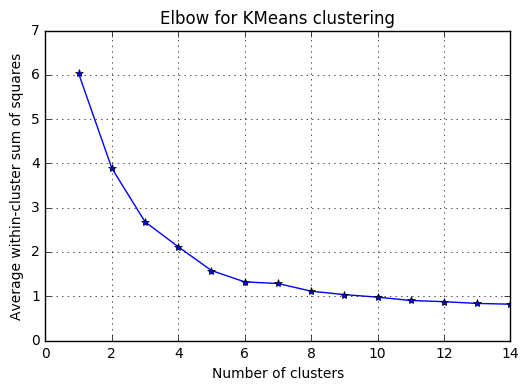

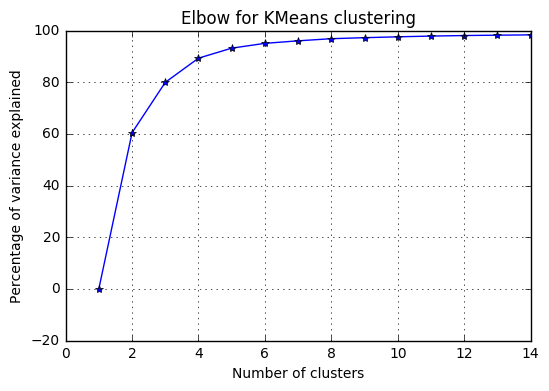

In [25]:
elbow(tots_vals, range(1,15))

The number of clusters is 6. Then we would make prominate components analysis of dataset.

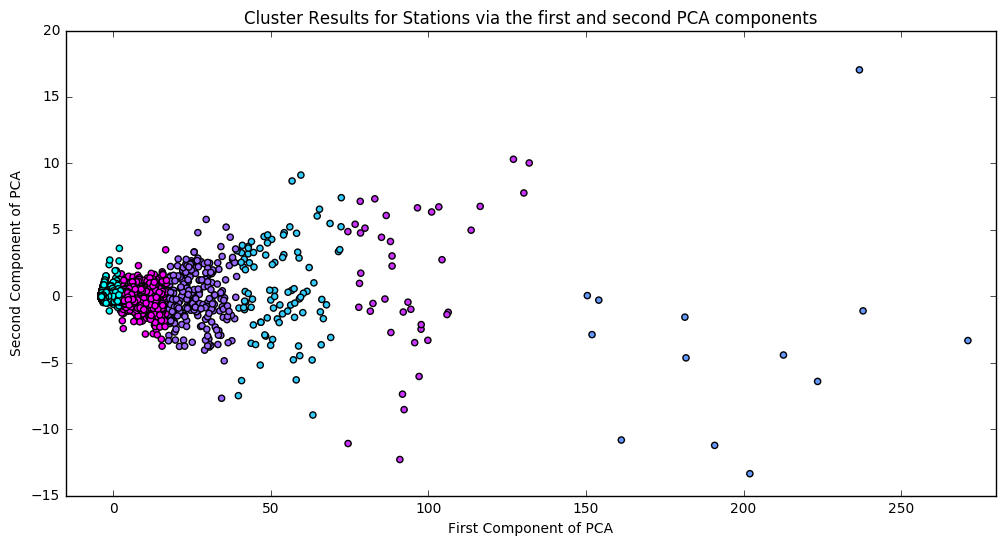

In [26]:
n = 6
km = KMeans(random_state=324,n_clusters=n)
res = km.fit(tots_vals)
reslabels = res.labels_
pca = PCA(194)
Xproj = pca.fit_transform(tots_vals)
pl.figure(figsize=(12, 6))
pl.scatter(Xproj[:, 0], Xproj[:, 1], c=reslabels, cmap=pl.cm.cool)
pl.xlim(-15,280)
pl.xlabel('First Component of PCA')
pl.ylabel('Second Component of PCA')
pl.title("Cluster Results for Stations via the first and second PCA components")
pl.show()